# Import libraries #

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
from jinja2.compiler import F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Download MNIST ##

In [11]:
# Define a transform to convert PIL images to tensors.
transform = transforms.ToTensor()

# Downloading the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Some DataSet Examination ##

Label is: 3; background value is 0.0; max value  is : 1.0, min value  is : 0.0


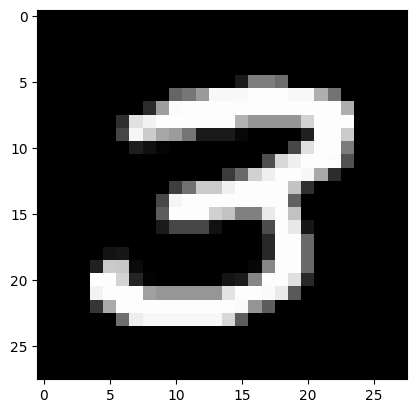

In [8]:
random_sample = random.randint(1,2000)
data,label = train_dataset[random_sample]
data_np = data.numpy()
min_val, max_val = data_np.min(), data_np.max()
median_val = np.median(data_np)

print(f"Label is: {label}; background value is {median_val}; max value  is : {max_val}, min value  is : {min_val}")

plt.imshow(data.squeeze().numpy(), cmap='gray')
plt.show()

## Define CNN ##


In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x) # softmax is included in the loss function
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is in use")

model = ConvNet().to(device)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda is in use


AttributeError: 'ConvNet' object has no attribute '_modules'

## Training Loop ##

In [ ]:
# Training loop:
num_epochs = 10
bath_size = 64
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/bath_size)
print(f"Number of iterations per epoch: {n_iterations}")

for epoch in range(num_epochs):
    for k,(images,labels) in enumerate(dataloader):
        # Transfer data to device:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass:
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Back propagation:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}")
